## "Изучение ЭЭГ: руководство для начинающих"

Если вас завораживают чудеса человеческого мозга и замысловатые узоры мозговых волн, но мир электроэнцефалографии (ЭЭГ) пугает, вы попали по адресу. 

Этот блокнот предназначен для новичков и призван разъяснить сложности данных ЭЭГ и сделать ваше обучение приятным и познавательным.

## 1 Замысел
В этом ноутбуке наша цель - предоставить четкое пошаговое руководство по пониманию и анализу сигналов ЭЭГ, которые имеют решающее значение для обнаружения и классификации активности мозга, например припадков. Мы постараемся:

* Разбить сложные концепции на легко усваиваемые разделы.
* Проиллюстрировать каждый шаг практическими примерами кода.


## 1.2 Цель обучения
К концу этого блокнота вы будете иметь фундаментальное представление о:

* Основы сигналов ЭЭГ и их значение в медицинских исследованиях и неврологии.
* Как проводить предварительную обработку и анализ данных ЭЭГ.
* Как построить модель машинного обучения для классификации данных ЭЭГ.

## 2. Ссылки и благодарности

Этот материал был бы невозможен без ценных идей и вклада сообщества Kaggle. Я использовал несколько ресурсов:
* https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-8
* https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
* https://www.kaggle.com/code/ksooklall/hms-banana-montage
* https://www.kaggle.com/code/mpwolke/seizures-classification-parquet

Не стесняйтесь изучать эти ресурсы, чтобы углубить свое понимание.

### 2.1 Исходные данные

Для этого исследования будем пользовтаься следующими даными:

https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/data


## 3. Библиотеки

In [47]:
import os
import pandas as pd, numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time

from scipy import signal
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

import optuna

import xgboost as xgb
import gc


VER = 1

## 4 ВВЕДЕНИЕ В ЭЭГ И ОБНАРУЖЕНИЕ ПРИПАДКОВ

### 4.1 Электроэнцефалография (ЭЭГ) - окно в деятельность мозга

* Электроэнцефалография, широко известная как ЭЭГ, - это неинвазивный метод, используемый медиками для регистрации электрической активности мозга. 
* Для этого используются электроды, расположенные на коже головы. 
* ЭЭГ - важнейший инструмент в диагностике неврологических заболеваний, особенно эпилепсии, которая характеризуется повторяющимися припадками.

<img src="https://www.researchgate.net/profile/Sebastian-Nagel-4/publication/338423585/figure/fig1/AS:844668573073409@1578396089381/Sketch-of-how-to-record-an-Electroencephalogram-An-EEG-allows-measuring-the-electrical.png" alt="EEG" width="600" height="400">



In [48]:
# Загрузим один из файлов и посмотрим на данные

BASE_PATH = 'hms-harmful-brain-activity-classification/'

df = pd.DataFrame({'path': glob(BASE_PATH + '**/*.parquet')})
df['test_type'] = df['path'].str.split('/').str.get(-2).str.split('_').str.get(-1)
df['id'] = df['path'].str.split('/').str.get(-1).str.split('.').str.get(0)

df_eeg = pd.read_parquet(BASE_PATH + 'train_eegs/1000913311.parquet')
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [49]:
df['path'][0]

'hms-harmful-brain-activity-classification/test_spectrograms/853520.parquet'

In [3]:
# Определим количество каналов
# Предположим, что каждая строка - это временная точка, а каждый столбец - канал
n_channels = df_eeg.shape[1]
n_channels

20

In [4]:
# перечень каналов
df_eeg.columns

Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'],
      dtype='object')

Посмотрим как выглядит один из вариантов ЭЭГ

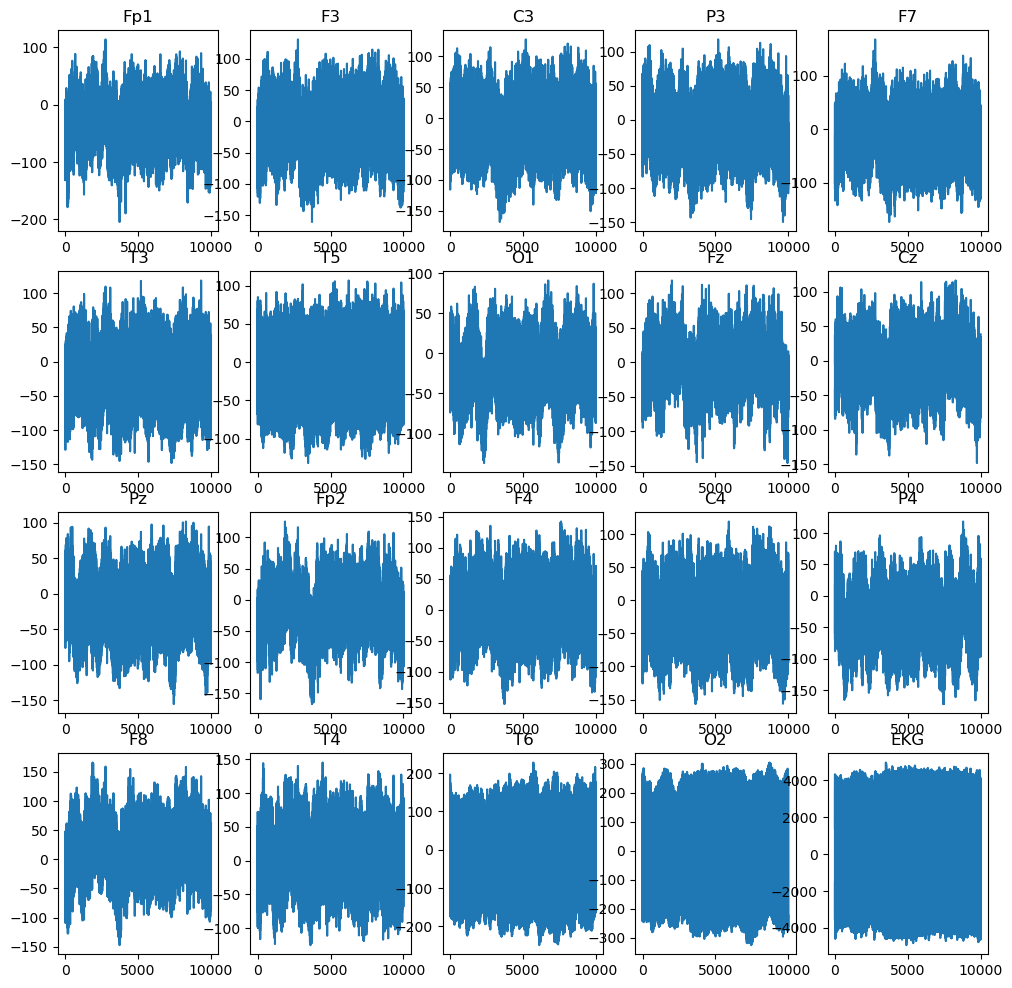

In [18]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12,12))
for row_n in range(4):
    for col_n in range(5):
        ax = axs[row_n, col_n]
        i = row_n * 5 + col_n
        ax.set_title(df_eeg.columns[i])
        ax.plot(df_eeg[df_eeg.columns[i]])
    

* Заголовки в наборе данных (Fp1, F3, C3, P3, F7, T3, T5, O1, Fz, Cz, Pz, Fp2, F4, C4, P4, F8, T4, T6, O2, EKG) - это стандартные метки расположения электродов, используемые в электроэнцефалографии (ЭЭГ). 
* Эти метки соответствуют определенным местам на голове, где размещаются электроды ЭЭГ для регистрации активности мозга. 
* Вот краткий перечень того, что они обозначают:

1. **Fp1, Fp2:** Фронтополярные электроды, расположенные на лбу, слева и справа.
2. **F3, F4:** Фронтальные электроды, расположенные на левой и правой стороне лба.
3. **C3, C4:** Центральные электроды, расположены над левым и правым полушариями мозга.
4. **P3, P4:** теменные электроды, расположены на верхней части затылка, с левой и правой стороны.
5. **O1, O2:** Затылочные электроды, расположенные на затылке рядом со зрительной корой.
6. **T3, T4, T5, T6:** Височные электроды, расположенные на левой и правой сторонах головы возле ушей. Они часто участвуют в мониторинге слуховых функций.
7. **F7, F8:** Лобно-темпоральные электроды, расположенные в передней части височных долей.
8. **Fz, Cz, Pz:** электроды средней линии, расположенные в лобной (Fz), центральной (Cz) и теменной (Pz) частях средней линии головы.
9. **ЭКГ:** Электрод для электрокардиограммы, регистрирующий электрическую активность сердца. Он не имеет прямого отношения к активности мозга, но может быть важен для некоторых анализов ЭЭГ.


<img src="https://www.researchgate.net/profile/Danny-Plass-Oude-Bos/publication/237777779/figure/fig3/AS:669556259434497@1536646060035/10-20-system-of-electrode-placement.png" alt="10-20-system-of-electrode-placement" width="300" height="150">

### 4.2 Припадки и их последствия
* Припадки - это внезапные, неконтролируемые электрические нарушения в мозге, которые могут вызывать изменения в поведении, чувствах, движениях и уровне сознания. 
* Точное обнаружение и классификация припадков жизненно важны для надлежащего лечения и ухода, особенно у тяжелобольных пациентов.

### 4.3 Сложность ручного анализа ЭЭГ

* Традиционно анализ данных ЭЭГ основывается на визуальном осмотре подготовленными неврологами. 
* Этот процесс не только занимает много времени и сил, но и чреват ошибками из-за усталости и субъективной интерпретации.

<img src="https://slideplayer.com/slide/12925171/78/images/2/Manual+Interpretation+of+EEGs.jpg" alt="Manual Interpretation of EEG" width="700" height="300">

Source: Automated Identification of Abnormal Adult EEG, S. López, G. Suarez, D. Jungreis, I. Obeid and J. Picone, Neural Engineering Data Consortium, Temple University


### 4.4 Роль науки о данных в анализе ЭЭГ

* Автоматизация интерпретации ЭЭГ
Появление машинного обучения и науки о данных открывает возможность автоматизировать интерпретацию данных ЭЭГ. Разрабатывая алгоритмы, способные обнаруживать и классифицировать различные паттерны в сигналах ЭЭГ, мы можем помочь неврологам быстрее и точнее ставить диагнозы.

* Подход науки о данных
Ученые, занимающиеся изучением данных, решают эту задачу путем предварительной обработки данных ЭЭГ, которая включает в себя фильтрацию шума и извлечение релевантных характеристик. Затем на этих признаках обучаются модели машинного обучения, позволяющие различать различные типы активности мозга.

<img src="https://www.researchgate.net/profile/Huiguang-He/publication/336336651/figure/fig1/AS:834361356197888@1575938657076/The-flow-chart-of-EEG-emotion-classification-with-similarity-learning-network.png" alt="flowchart for EEG classification" width="700" height="300">


### 4.5 Понимание паттернов ЭЭГ

В области анализа ЭЭГ для обнаружения припадков особый интерес представляют некоторые закономерности:

1. **Припадок (SZ):** Характеризуется аномальной ритмической активностью, свидетельствующей о припадке.
2. **Генерализованные периодические разряды (ГПР):** Паттерны, которые могут наблюдаться при различных энцефалопатиях.
3. **Латерализованные периодические разряды (ЛПР):** Часто связаны с очаговыми поражениями мозга.
4. **Латерализованная ритмическая дельта-активность (ЛРДА):** Может наблюдаться при очаговой дисфункции мозга.
5. **Генерализованная ритмическая дельта-активность (GRDA):** Обычно связана с диффузной дисфункцией мозга.
6. **"Другие" паттерны:** Любой другой тип активности, не относящийся к вышеперечисленным категориям.

### 4.6 Интерпретация сложных данных ЭЭГ

Интерпретация данных ЭЭГ может быть сложной, особенно в краевых случаях, когда эксперты-неврологи не могут прийти к единому мнению относительно классификации. Именно здесь модели машинного обучения могут особенно ярко проявить себя, обеспечив дополнительный уровень анализа.

<img src="https://www.neurology.org/cms/10.1212/WNL.0000000000207127/asset/bd84c182-712c-41ab-8742-cecf9d49a322/assets/images/large/5ff2.jpg" alt="flowchart for EEG classification" width="700" height="300">

Source: Development of Expert-Level Classification of Seizures and Rhythmic and Periodic Patterns During EEG Interpretation https://www.neurology.org/doi/10.1212/WNL.0000000000207127


## Загрузка данных

### Файлы:

#### train.csv
`train.csv` Метаданные для обучающего набора. Эксперты-аннотаторы просмотрели 50-секундные образцы ЭЭГ плюс соответствующие спектрограммы, охватывающие 10-минутное окно с центром в одно и то же время, и пометили центральные 10 секунд. Многие из этих образцов перекрывались и были объединены. В файле `train.csv` содержатся метаданные, позволяющие извлечь исходные подмножества, которые аннотировали эксперты.

* eeg_id - Уникальный идентификатор для всей записи ЭЭГ.
* eeg_sub_id - идентификатор конкретной подвыборки длиной 50 секунд, к которой относятся метки этой строки.
* eeg_label_offset_seconds - Время между началом консолидированной ЭЭГ и данной подвыборкой.
* spectrogram_id - уникальный идентификатор для всей записи ЭЭГ.
* spectrogram_sub_id - идентификатор конкретной 10-минутной подвыборки, к которой относятся метки этой строки.
* spectogram_label_offset_seconds - Время между началом сводной спектрограммы и данной подвыборкой.
* label_id - Идентификатор для данного набора меток.
* patient_id - Идентификатор пациента, предоставившего данные.
* expert_consensus - метка консенсусного аннотатора. Предоставлено только для удобства.
* [seizure/lpd/gpd/lrda/grda/other]_vote - Количество голосов аннотаторов для данного класса активности мозга. Полные названия классов активности следующие:
	* lpd: латерализованные периодические разряды, 
	* gpd: генерализованные периодические разряды, 
	* lrd: латерализованная ритмическая дельта-активность и 
	* grda: генерализованная ритмическая дельта-активность. 
Подробное объяснение этих паттернов можно найти [здесь](https://www.acns.org/UserFiles/file/ACNSStandardizedCriticalCareEEGTerminology_rev2021.pdf).

#### test.csv
`test.csv` Метаданные для тестового набора. Поскольку в тестовом наборе нет перекрывающихся образцов, многие столбцы метаданных тренинга не применяются.

* eeg_id - идентификатор ээг
* spectrogram_id - идентификатор спектрограммы
* patient_id - идентификатор пациента

#### Каталог train_eegs
Данные ЭЭГ из одного или нескольких перекрывающихся образцов. Используйте метаданные в `train.csv` для выбора конкретных аннотированных подмножеств. Названия столбцов - [это названия отдельных мест расположения электродов для отведений ЭЭГ](https://en.wikipedia.org/wiki/10–20_system_%28EEG%29), за одним исключением. Столбец EKG обозначает электрокардиограмму, которая регистрирует данные сердца. Все данные ЭЭГ (как для тренировки, так и для теста) были собраны с частотой 200 образцов в секунду.

#### Каталог train_spectrograms
Спектрограммы, собранные из данных ЭЭГ. Используйте метаданные в файле `train.csv` для выбора конкретных аннотированных подмножеств. В названиях столбцов указана частота в герцах и области записи электродов ЭЭГ, которые сокращенно обозначены как:
* LL = левый латеральный;
* RL = правый латеральный; 
* LP = левый парасагиттальный; 
* RP = правый парасагиттальный.

Подробнее про описание исходных данных можно прочитать здесь: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/data

In [50]:
df = pd.read_csv('hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


## 6 Создание непересекающихся тренировочных данных EEG ID

Следуя ноутбуку от Криса Деотта: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-8,

и обсуждению: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021.

Мы выполняем следующие действия:

* **Соответствие форматов тренировочных и тестовых данных:** Тестовые данные не должны содержать несколько сегментов с одним и тем же eeg_id. Чтобы привести формат тренировочных данных похожим на тестовые, мы также используем только один сегмент на eeg_id в обучающих данных.

* **Удаление избыточности:** Этот подход гарантирует, что в обучающих данных не будет дублирующей или избыточной информации, что может привести к созданию переобученной или неверной модели машинного обучения.

* **Согласованность данных:** Стандартизируя способы обработки сегментов ЭЭГ в процессе обучения, мы гарантируем, что наша модель будет обучаться на данных, которые по формату совпадают с данными, на которых она будет тестироваться.

* **Подготовка данных для машинного обучения:** Нормализация целевых переменных и включение релевантных характеристик, таких как patient_id и expert_consensus, позволит использовать набор данных для эффективного моделирования с помощью машинного обучения.

In [51]:
# Создание уникального сегмента ЭЭГ для каждого eeg_id:
# Код группирует (groupby) данные ЭЭГ (df) по eeg_id. Каждый eeg_id представляет собой отдельную запись ЭЭГ.
# Затем выбирается первый идентификатор спектрограммы и самое раннее (минимальное) смещение_метки_секунды спектрограммы для каждого eeg_id. Это помогает определить начальную точку каждого сегмента ЭЭГ.
# Результирующий состав DataFrame имеет колонки spec_id (первый идентификатор спектрограммы) и min (самая ранняя метка спектрограммы_смещение_секунды).
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']


# Нахождение последней точки в каждом сегменте ЭЭГ:
# Код снова группирует данные по eeg_id и находит последнее (максимальное) значение спектрограммы_метки_смещения_секунды для каждого сегмента.
# Это максимальное значение добавляется в train DataFrame, представляя собой конечную точку каждого сегмента ЭЭГ.
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp


# Добавляем идентификатор пациента для каждого eeg_id в train DataFrame. Это связывает каждый сегмент ЭЭГ с конкретным пациентом.
tmp = df.groupby('eeg_id')[['patient_id']].agg('first') 
train['patient_id'] = tmp


# Суммируем подсчеты целевых переменных (например, голосов за приступ, LPD и т. д.) для каждого eeg_id.
tmp = df.groupby('eeg_id')[TARGETS].agg('sum') 
for t in TARGETS:
    train[t] = tmp[t].values
    

# Затем нормализуем эти подсчеты так, чтобы их сумма равнялась 1. 
# Этот шаг преобразует подсчеты в вероятности, что является обычной практикой в задачах классификации.
y_data = train[TARGETS].values 
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data


# Для каждого eeg_id включаем экспертное_согласие по классификации сегмента ЭЭГ.
tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first') 
train['target'] = tmp


# Делаем eeg_id обычным столбцом, что упрощает работу с DataFrame.
train = train.reset_index() 
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


## Конструирование признаков



* Приведенный ниже код эффективно считывает данные спектрограммы из одного комбинированного файла на основе переменной set. Для экономии времени мы использовали набор данных Криса Деотта. https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
* Затем он выполняет построение признаков, вычисляя средние и минимальные значения в двух разных временных окнах для каждой частоты в спектрограмме.
В результате получается 1600 признаков (400 признаков × 4 расчета) для каждого идентификатора ЭЭГ.
* Новые признаки призваны помочь модели лучше понять и классифицировать данные ЭЭГ.
* Этот подход призван повысить эффективность модели за счет предоставления ей более подробной информации, полученной из данных спектрограммы.

In [52]:
READ_SPEC_FILES = False # If READ_SPEC_FILES is False, the code reads the combined file instead of individual files.
FEATURE_ENGINEER = True

In [53]:
# %%time
# READ ALL SPECTROGRAMS
PATH = 'hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
    if not os.path.exists('brain-spectrograms'):
        os.mkdir('brain-spectrograms')
    np.save('brain-spectrograms/specs.npy', spectrograms)
else:
    spectrograms = np.load('brain-spectrograms/specs.npy',allow_pickle=True).item()
    

There are 11138 spectrogram parquets


In [54]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# Код генерирует признаки из данных спектрограммы для использования в модели 
# Характеристики получаются путем вычисления средних и минимальных значений со временем для каждой из 400 частот спектрограммы.
# Для этих расчетов используются два типа окон:
# 10-минутное окно (_mean_10m, _min_10m).
# 20-секундное окно (_mean_20s, _min_20s).
# В результате этого процесса для каждого идентификатора ЭЭГ получается 1600 признаков (400 признаков × 4 расчета).

SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')


# Инициализируется матрица данных data для хранения новых признаков для каждого eeg_id в train DataFrame.
# Для каждой строки в train код вычисляет среднее и минимальное значения в указанных 10-минутном и 20-секундном окнах.
# Эти вычисленные значения затем сохраняются в матрице данных.
# Наконец, матрица добавляется в train DataFrame в виде новых столбцов.

if FEATURE_ENGINEER:
    data = np.zeros((len(train),len(FEATURES)))
    for k in tqdm(range(len(train))):
        # if k%100==0: print(k,', ',end='')
        row = train.iloc[k]
        r = int( (row['min'] + row['max'])//4 ) 
        
        # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,:400] = x
        x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,400:800] = x
        
        # 20 SECOND WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,800:1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,1200:1600] = x

    train[FEATURES] = data
else:
    train = pd.read_parquet('/kaggle/input/brain-spectrograms/train.pqt')
print()
print('New train shape:',train.shape)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
We are creating 1600 features for 17089 rows... 

100%|██████████| 17089/17089 [00:29<00:00, 575.07it/s]



New train shape: (17089, 1612)


### 7.2 Анализ частотных диапазонов

#### Извлечение признаков частотных полос:

* Функция extract_frequency_band_features предназначена для обработки сегмента данных ЭЭГ. Данные ЭЭГ - это сложный сигнал, который представляет собой электрическую активность мозга.
* Эта функция делит сигнал ЭЭГ на различные частотные диапазоны: Дельта, Тета, Альфа, Бета и Гамма. Эти диапазоны важны для нейронаучных исследований, поскольку они связаны с различными состояниями и видами деятельности мозга.

![](https://ars.els-cdn.com/content/image/3-s2.0-B9780128044902000026-f02-01-9780128044902.jpg)


1. **Дельта-волны (0,5-4 Гц):**.
Дельта-волны - это самые медленные мозговые волны, которые обычно ассоциируются с глубоким сном и восстановительными процессами в организме. Они наиболее заметны во время сна без сновидений и играют роль в исцелении и регенерации.
2. **Тета (4 - 8 Гц):**.
Тета-волны возникают во время легкого сна, глубокой медитации и REM (Rapid Eye Movement) сна. Они связаны с творчеством, интуицией, дневными мечтами и фантазиями. Тета-состояния часто ассоциируются с деятельностью подсознания.
3. **Альфа (8 - 12 Гц):**.
Альфа-волны присутствуют во время физического и психического расслабления, но при этом остаются бдительными. Они характерны для состояний бодрствования, когда человек расслаблен и без усилий сохраняет бдительность. Альфа-волны способствуют умственной координации, спокойствию, бдительности и обучению.
4. **Бета-волны (12 - 30 Гц):**.
Бета-волны доминируют в нашем обычном состоянии бодрствования, когда внимание направлено на когнитивные задачи и внешний мир. Они ассоциируются с активным, напряженным или тревожным мышлением и активной концентрацией.
5. **Гамма (30-45 Гц):**.
Гамма-волны участвуют в высшей психической деятельности и консолидации информации. Они важны для обучения, памяти и обработки информации. Гамма-волны считаются самой быстрой частотой мозговых волн и связаны с одновременной обработкой информации из разных областей мозга.



* Для каждого частотного диапазона функция применяет частотный фильтр, чтобы выделить сигнал этого диапазона. Затем она вычисляет статистические характеристики (среднее значение, стандартное отклонение, максимум и минимум) для каждой полосы, эффективно фиксируя характеристики сигнала ЭЭГ в этих различных частотных диапазонах.
* Использование np.nanmean, np.nanstd, np.nanmax и np.nanmin обеспечивает устойчивость расчетов к значениям NaN (Not a Number) в данных, которые могут возникать по разным причинам, например из-за потери сигнала или артефактов.

#### Агрегирование признаков и PCA:

* Основной скрипт инициализирует модель анализа главных компонент (PCA) с целью снижения размерности извлеченных признаков. PCA - это распространенная техника, используемая для преобразования высокоразмерных наборов данных в более низкоразмерное пространство с сохранением большей части дисперсии в данных.
* Сценарий перебирает строки обучающего набора данных, выделяя сегменты ЭЭГ и применяя функцию extract_frequency_band_features к каждому каналу в этих сегментах. Извлеченные признаки из всех каналов агрегируются.
* Перед применением PCA все значения NaN в агрегированных данных (data_original) заменяются на среднее. Этот шаг гарантирует, что алгоритм PCA, который не может работать с NaN-значениями, получит чистый набор данных.
* После заполнения пропусков применяется PCA для преобразования признаков в пространство главных компонент, и эти преобразованные признаки добавляются обратно в обучающий набор данных.
* Этот процесс в конечном итоге приводит к набору признаков, который потенциально более информативен и краток для моделей машинного обучения, что помогает в таких задачах, как классификация или обнаружение аномалий в данных ЭЭГ.

In [56]:
def extract_frequency_band_features(segment):
    # Define EEG frequency bands
    eeg_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 45)}
    
    band_features = []
    for band in eeg_bands:
        low, high = eeg_bands[band]
        # Filter signal for the specific band
        band_pass_filter = signal.butter(3, [low, high], btype='bandpass', fs=200, output='sos')
        filtered = signal.sosfilt(band_pass_filter, segment)
        # Extract features like mean, standard deviation, etc.
        band_features.extend([np.nanmean(filtered), np.nanstd(filtered), np.nanmax(filtered), np.nanmin(filtered)])
    
    return band_features

In [57]:
PROCESS_PCA = False

if PROCESS_PCA:
	# Initialize a PCA model
	pca = PCA(n_components=0.95)
	print("PCA model initialized.")

	# Initialize an array for original features
	num_rows = len(train)
	num_features = 20 * n_channels  # 20 features per channel
	data_original = np.zeros((num_rows, num_features))

	print("Starting feature extraction and PCA processing...")
	start_time = time.time()

	for k in tqdm(range(num_rows)):
		# if k % 1000 == 0:
		#     print(f"Processing row {k} of {num_rows}...")

		row = train.iloc[k]
		r = int((row['min'] + row['max']) // 4)
		eeg_segment = spectrograms[row.spec_id][r:r+300, :]

		# Apply the feature extraction function to each EEG channel
		all_channel_features = []
		for i in range(n_channels):
			channel_features = extract_frequency_band_features(eeg_segment[:, i])
			all_channel_features.extend(channel_features)
		
		data_original[k, :] = all_channel_features

	print("Data matrix constructed")

	# Impute NaN values in the data matrix
	imputer = SimpleImputer(strategy='mean')
	data_imputed = imputer.fit_transform(data_original)

	print(f"NaN values handled. Imputed data matrix shape: {data_imputed.shape}")

	# Apply PCA on the imputed data
	pca.fit(data_imputed)
	print("PCA fitting completed.")

	# Transform data using PCA
	data_pca = pca.transform(data_imputed)

	# Add PCA features to DataFrame
	pca_feature_columns = [f'pca_feature_{i}' for i in range(data_pca.shape[1])]
	train[pca_feature_columns] = data_pca
	
	# save train data
	if not os.path.exists('pca-data'):
		os.mkdir('pca-data')

	train.to_csv('pca-data/train.csv', index=False)

	# Measure total processing time
	total_time = time.time() - start_time
	print(f"Total processing time: {total_time:.2f} seconds.")
else:
	train = pd.read_csv('pca-data/train.csv')

In [58]:
train.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,RP_19.14_min_20s,RP_19.34_min_20s,RP_19.53_min_20s,RP_19.73_min_20s,RP_19.92_min_20s,pca_feature_0,pca_feature_1,pca_feature_2,pca_feature_3,pca_feature_4
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,0.21,0.17,0.19,0.15,0.13,-1.791975e+06,129964.277228,-72723.289793,-4408.413237,30855.511329
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,0.02,0.03,0.02,0.02,0.02,-1.815642e+06,141526.809013,-72784.655164,-4977.295332,31734.200103
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.06,0.03,0.06,0.05,0.05,-1.815923e+06,141594.495060,-72571.734796,-5000.744594,31710.260616
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,0.06,0.07,0.05,0.05,0.03,-1.815793e+06,141721.336394,-72572.843787,-4976.515387,31636.354209
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,0.06,0.06,0.12,0.09,0.04,-1.814062e+06,139983.235315,-73528.975515,-5198.633411,31213.258061


In [59]:
# Columns to be excluded from scaling
excluded_columns = ['eeg_id', 'spec_id', 'min', 'max', 'patient_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote','target']

# Save the columns to be excluded
excluded_data = train[excluded_columns]

# DataFrame with only the columns to be scaled
features = train.drop(columns=excluded_columns)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features and transform them
features_scaled = scaler.fit_transform(features)

# Create a DataFrame from the scaled features
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Concatenate the scaled features with the excluded columns
train_scaled_df = pd.concat([excluded_data.reset_index(drop=True),features_scaled_df,], axis=1)

train_scaled_df.head() 


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,RP_19.14_min_20s,RP_19.34_min_20s,RP_19.53_min_20s,RP_19.73_min_20s,RP_19.92_min_20s,pca_feature_0,pca_feature_1,pca_feature_2,pca_feature_3,pca_feature_4
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,-0.025752,-0.026022,-0.026978,-0.024814,-0.026100,-0.193142,0.060882,-0.050816,-0.003904,0.032481
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,-0.025768,-0.026030,-0.026982,-0.024815,-0.026101,-0.195693,0.066299,-0.050859,-0.004408,0.033406
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,-0.025765,-0.026030,-0.026981,-0.024815,-0.026101,-0.195723,0.066331,-0.050710,-0.004429,0.033381
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,-0.025765,-0.026027,-0.026982,-0.024815,-0.026101,-0.195709,0.066390,-0.050711,-0.004407,0.033303
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,-0.025765,-0.026028,-0.026980,-0.024814,-0.026101,-0.195523,0.065576,-0.051379,-0.004604,0.032858


In [60]:
train_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17089 entries, 0 to 17088
Columns: 1617 entries, eeg_id to pca_feature_4
dtypes: float64(1613), int64(3), object(1)
memory usage: 210.8+ MB


In [62]:
train_scaled_df['target'].value_counts()

target
Other      7196
Seizure    2785
LPD        2577
GRDA       1828
GPD        1787
LRDA        916
Name: count, dtype: int64

## 8. Train Model

In [57]:
print('XGBoost version', xgb.__version__)

XGBoost version 1.7.6


In [63]:
# Внимание, обучение ~ 17 минут!
TRAIN_MODEL = False

all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train , train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    # print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    # print('#'*25)
    
    model = xgb.XGBClassifier(
        objective='multi:softprob', 
        num_class=len(TARS),
        learning_rate = 0.1, 

#         tree_method='gpu_hist',  #skip GPU acceleration
    )
    
    # Prepare training and validation data
    X_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'target'].map(TARS)
    X_valid = train.loc[valid_index, FEATURES]
    y_valid = train.loc[valid_index, 'target'].map(TARS)
    
    if TRAIN_MODEL:
        model.fit(X_train, y_train, 
				eval_set=[(X_valid, y_valid)], 
				verbose=True, 
				early_stopping_rounds=10)
        model.save_model(f'models/XGB_v{VER}_f{i}.model')
    else:
        model.load_model(f'models/XGB_v{VER}_f{i}.model')
    
    oof = model.predict_proba(X_valid)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)
    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)


#########################
### Fold 1
#########################
### Fold 2
#########################
### Fold 3
#########################
### Fold 4
#########################
### Fold 5


### 8.1 Проверим качество модели "из коробки"

In [112]:
model = xgb.XGBClassifier(
        objective='multi:softprob', 
        num_class=len(TARS),
        learning_rate = 0.1, 
    )
model.load_model(f'models/XGB_v{VER}_f{i}.model')

for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
	X_train, X_valid = train.loc[train_index, FEATURES], train.loc[valid_index, FEATURES]
	y_train, y_valid = train.loc[train_index, 'target'].map(TARS), train.loc[valid_index, 'target'].map(TARS)

	# model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=10)
	preds = model.predict_proba(X_valid)
	print(f'Fold: {i}, log-loss: {log_loss(y_valid, preds)}')

Fold: 0, log-loss: 0.3538404246214232
Fold: 1, log-loss: 0.33666234516744026
Fold: 2, log-loss: 0.3386534028597076
Fold: 3, log-loss: 0.36578572164412815
Fold: 4, log-loss: 1.140261683144077


## 9. Настройка гиперпараметров

### 9.1 Импорт библиотек и настройка Optuna
* Импортируем необходимые библиотеки: optuna для оптимизации гиперпараметров, xgboost для модели машинного обучения, log_loss из scikit-learn для метрики оценки и GroupKFold для кросс-валидации.
* optuna.create_study(direction='minimize') создает новое оптимизационное исследование. Направление='minimize' означает, что вы хотите минимизировать значение, возвращаемое объективной функцией, которая в данном случае является log loss.

### 9.2 Определение целевой функции
* Целевая функция - это то, что Optuna будет оптимизировать. Эта функция принимает пробный объект, который используется, чтобы предложить значения для гиперпараметров.
* Внутри этой функции задается пространство гиперпараметров. Optuna будет тестировать различные комбинации этих параметров:
1. лямбда, альфа: Параметры регуляризации.
2. colsample_bytree, subsample: Коэффициенты для выборки столбцов и строк.
3. learning_rate: Скорость обучения.
4. n_estimators: Количество деревьев.
5. max_depth: Максимальная глубина дерева.
6. min_child_weight: Минимальная сумма весов экземпляров в дочернем дереве.

### 9.3 Цикл кросс-валидации

* Функция использует GroupKFold для разделения данных. Этот метод подходит, когда в данных есть группы (например, идентификаторы пациентов), которые не должны быть разделены на обучающий и проверочный наборы.
* Для каждого фолда в кросс-валидации функция:
1. Разделяет данные на обучающий и проверочный наборы.
2. Обучает модель XGBoost, используя параметры, предложенные Optuna.
3. Вычисляет лог-потери на валидационном множестве.
4. Возвращается среднее значение log loss по всем фолдам. Optuna будет использовать это значение, чтобы решить, какие гиперпараметры лучше.

### 9.4 Запуск исследования Optuna

* study.optimize(objective, n_trials=100) дает команду Optuna на оптимизацию функции цели. Она попробует 100 различных комбинаций гиперпараметров (n_trials=100), чтобы найти лучшие.
* Лучше всего начинать с небольших испытаний, прежде чем тратить время на большее количество вариаций, чтобы сэкономить время.
* После завершения оптимизации будут выведены наилучшие найденные гиперпараметры.

In [110]:
# def objective(trial):
#     # Hyperparameters to be tuned by Optuna
#     param = {
#         'objective': 'multi:softprob',
#         'num_class': len(TARS),
#         # 'tree_method': 'gpu_hist',  # use 'gpu_hist' for GPU
#         'lambda': trial.suggest_loguniform('lambda', 1e-4, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-4, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.02, 0.05, 0.1]),
#         'n_estimators': 1000,
#         'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }

#     gkf = GroupKFold(n_splits=5)
#     cv_scores = []

#     for train_index, valid_index in gkf.split(train, train.target, train.patient_id):
#         X_train, X_valid = train.loc[train_index, FEATURES], train.loc[valid_index, FEATURES]
#         y_train, y_valid = train.loc[train_index, 'target'].map(TARS), train.loc[valid_index, 'target'].map(TARS)

#         model = xgb.XGBClassifier(**param)
#         model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=10)
#         preds = model.predict_proba(X_valid)
#         cv_scores.append(log_loss(y_valid, preds))

#     return np.mean(cv_scores)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)  # Increase n_trials for more extensive search

# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

* [I 2024-01-15 06:06:55,585] A new study created in memory with name: no-name-21c5e987-7941-4f05-8e92-2903b9a7e304
* [I 2024-01-15 06:20:36,414] Trial 0 finished with value: 1.0734795198486586 and parameters: {'lambda': 8.578460041884545, 'alpha': 1.0420327876364774, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 30}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 06:39:35,894] Trial 1 finished with value: 1.0792154540612213 and parameters: {'lambda': 0.0029055528938438085, 'alpha': 0.03244985452963714, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 77}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 06:42:19,332] Trial 2 finished with value: 1.107279543251576 and parameters: {'lambda': 1.5919274718287213, 'alpha': 0.042136459342788604, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 152}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 06:57:56,577] Trial 3 finished with value: 1.107956784549986 and parameters: {'lambda': 6.873357111288177, 'alpha': 0.05538406375764404, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 7, 'min_child_weight': 108}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:12:36,921] Trial 4 finished with value: 1.1453593669298952 and parameters: {'lambda': 0.0012348624625841455, 'alpha': 6.698933350539058, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 258}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:27:45,543] Trial 5 finished with value: 1.1234561427497631 and parameters: {'lambda': 0.0779496745099949, 'alpha': 0.001997110519034328, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 11, 'min_child_weight': 145}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:30:45,104] Trial 6 finished with value: 1.139466297500727 and parameters: {'lambda': 0.011643281906929, 'alpha': 0.06334100511005662, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 274}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:33:47,478] Trial 7 finished with value: 1.074140292040741 and parameters: {'lambda': 5.487810272015954, 'alpha': 2.266845998962579, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 51}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:48:19,863] Trial 8 finished with value: 1.1705891200455967 and parameters: {'lambda': 0.03333036846711228, 'alpha': 0.0004482362892025373, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 13, 'min_child_weight': 294}. Best is trial 0 with value: 1.0734795198486586.
* [I 2024-01-15 07:53:41,442] Trial 9 finished with value: 1.115599617296683 and parameters: {'lambda': 0.000284724944614318, 'alpha': 0.020480207664040264, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 248}. Best is trial 0 with value: 1.0734795198486586.
Number of finished trials: 10

* **Best trial: {'lambda': 8.578460041884545, 'alpha': 1.0420327876364774, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 30}**

In [114]:
# Внимание, считается около 3 часов!
TRAIN_MODEL = False

param = {
        'objective': 'multi:softprob',
        'num_class': len(TARS),
        'n_estimators': 1000,
        'lambda': 8.578460041884545,
		'alpha': 1.0420327876364774,
		'colsample_bytree': 1.0,
		'subsample': 1.0, 
		'learning_rate': 0.02, 
		'max_depth': 7, 
		'min_child_weight': 30
    }

gkf = GroupKFold(n_splits=5)
cv_scores = []

for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
	X_train, X_valid = train.loc[train_index, FEATURES], train.loc[valid_index, FEATURES]
	y_train, y_valid = train.loc[train_index, 'target'].map(TARS), train.loc[valid_index, 'target'].map(TARS)

	model = xgb.XGBClassifier(**param)
	if TRAIN_MODEL:
		model.fit(X_train, y_train, 
				eval_set=[(X_valid, y_valid)], 
				verbose=True, 
				early_stopping_rounds=10)
		model.save_model(f'models/XGB_opt_v{VER}_f{i}.model')
	else:
		model.load_model(f'models/XGB_opt_v{VER}_f{i}.model')
        
	preds = model.predict_proba(X_valid)
	cv_scores.append(log_loss(y_valid, preds))
	print(f'Fold: {i}, log-loss: {log_loss(y_valid, preds)}')

print(np.mean(cv_scores))

[0]	validation_0-mlogloss:1.77701
[1]	validation_0-mlogloss:1.76293
[2]	validation_0-mlogloss:1.74949
[3]	validation_0-mlogloss:1.73628
[4]	validation_0-mlogloss:1.72356
[5]	validation_0-mlogloss:1.71115
[6]	validation_0-mlogloss:1.69917
[7]	validation_0-mlogloss:1.68727
[8]	validation_0-mlogloss:1.67625
[9]	validation_0-mlogloss:1.66540
[10]	validation_0-mlogloss:1.65421
[11]	validation_0-mlogloss:1.64387
[12]	validation_0-mlogloss:1.63351
[13]	validation_0-mlogloss:1.62376
[14]	validation_0-mlogloss:1.61453
[15]	validation_0-mlogloss:1.60490
[16]	validation_0-mlogloss:1.59591
[17]	validation_0-mlogloss:1.58681
[18]	validation_0-mlogloss:1.57817
[19]	validation_0-mlogloss:1.56970
[20]	validation_0-mlogloss:1.56159
[21]	validation_0-mlogloss:1.55333
[22]	validation_0-mlogloss:1.54573
[23]	validation_0-mlogloss:1.53766
[24]	validation_0-mlogloss:1.53028
[25]	validation_0-mlogloss:1.52285
[26]	validation_0-mlogloss:1.51571
[27]	validation_0-mlogloss:1.50895
[28]	validation_0-mlogloss:1.5

## Оценка значимости признаков

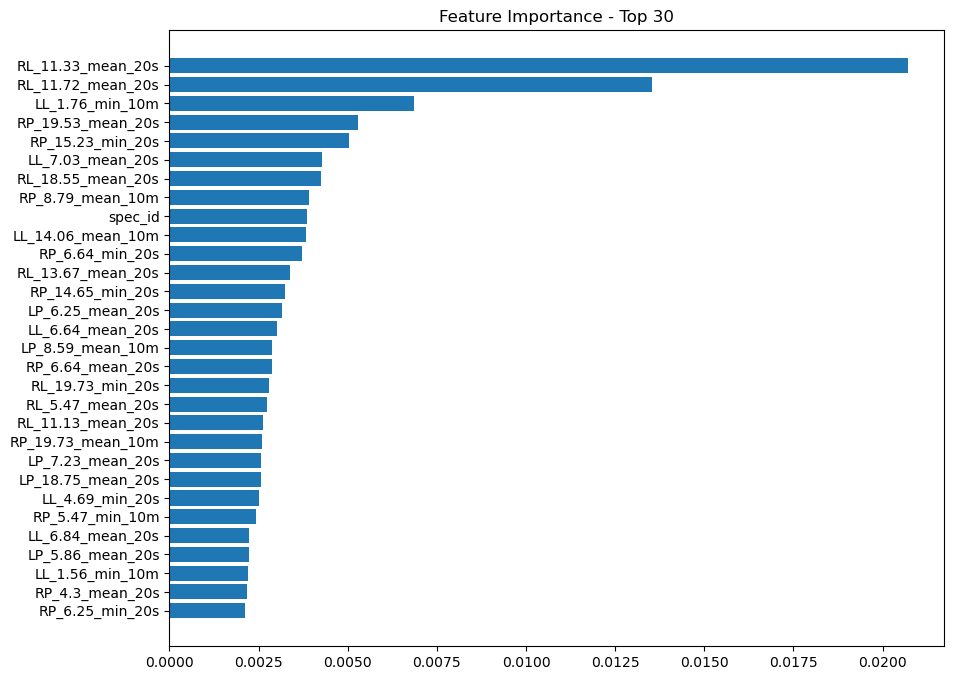

In [115]:
TOP = 30

# Assuming 'model' is your trained model
feature_importance = model.feature_importances_

# Get the feature names from 'train'
feature_names = train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()